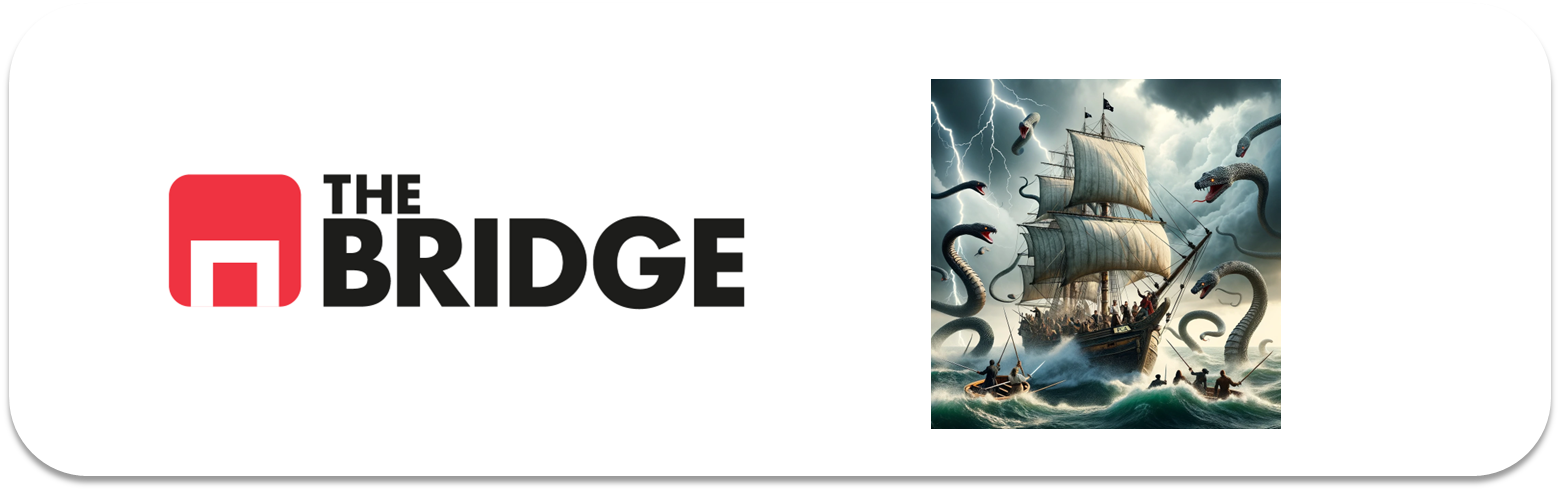

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [ ]:
df = pd.read_csv(r'C:\DATA_SCIENCE\MASTER DATA SCIENCE\Prácticas Máster Data Science\Practicas_Data_Science\Prácticas Python\Ejercicios Sprint 14 - ML Modelos No Supervisados II – PC y Feature Selection\Unidad_02\Practica_Obligatoria\data\credit_npo.csv')
df.head(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [4]:
# Deshacerse de las filas con valores nulos
df = df.dropna()

In [5]:
# Convertir las features NumberOf... a categóricas con 2 o 3 niveles
df['NumberOfDependents'] = pd.cut(df['NumberOfDependents'], bins=[-1, 0, 2, float('inf')], labels=['0', '1-2', '3+'])
df['NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(df['NumberOfTime30-59DaysPastDueNotWorse'], bins=[-1, 0, 1, float('inf')], labels=['0', '1', '2+'])
df['NumberOfTimes90DaysLate'] = pd.cut(df['NumberOfTimes90DaysLate'], bins=[-1, 0, 1, float('inf')], labels=['0', '1', '2+'])
df['NumberRealEstateLoansOrLines'] = pd.cut(df['NumberRealEstateLoansOrLines'], bins=[-1, 0, 1, float('inf')], labels=['0', '1', '2+'])
df['NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(df['NumberOfTime60-89DaysPastDueNotWorse'], bins=[-1, 0, 1, float('inf')], labels=['0', '1', '2+'])

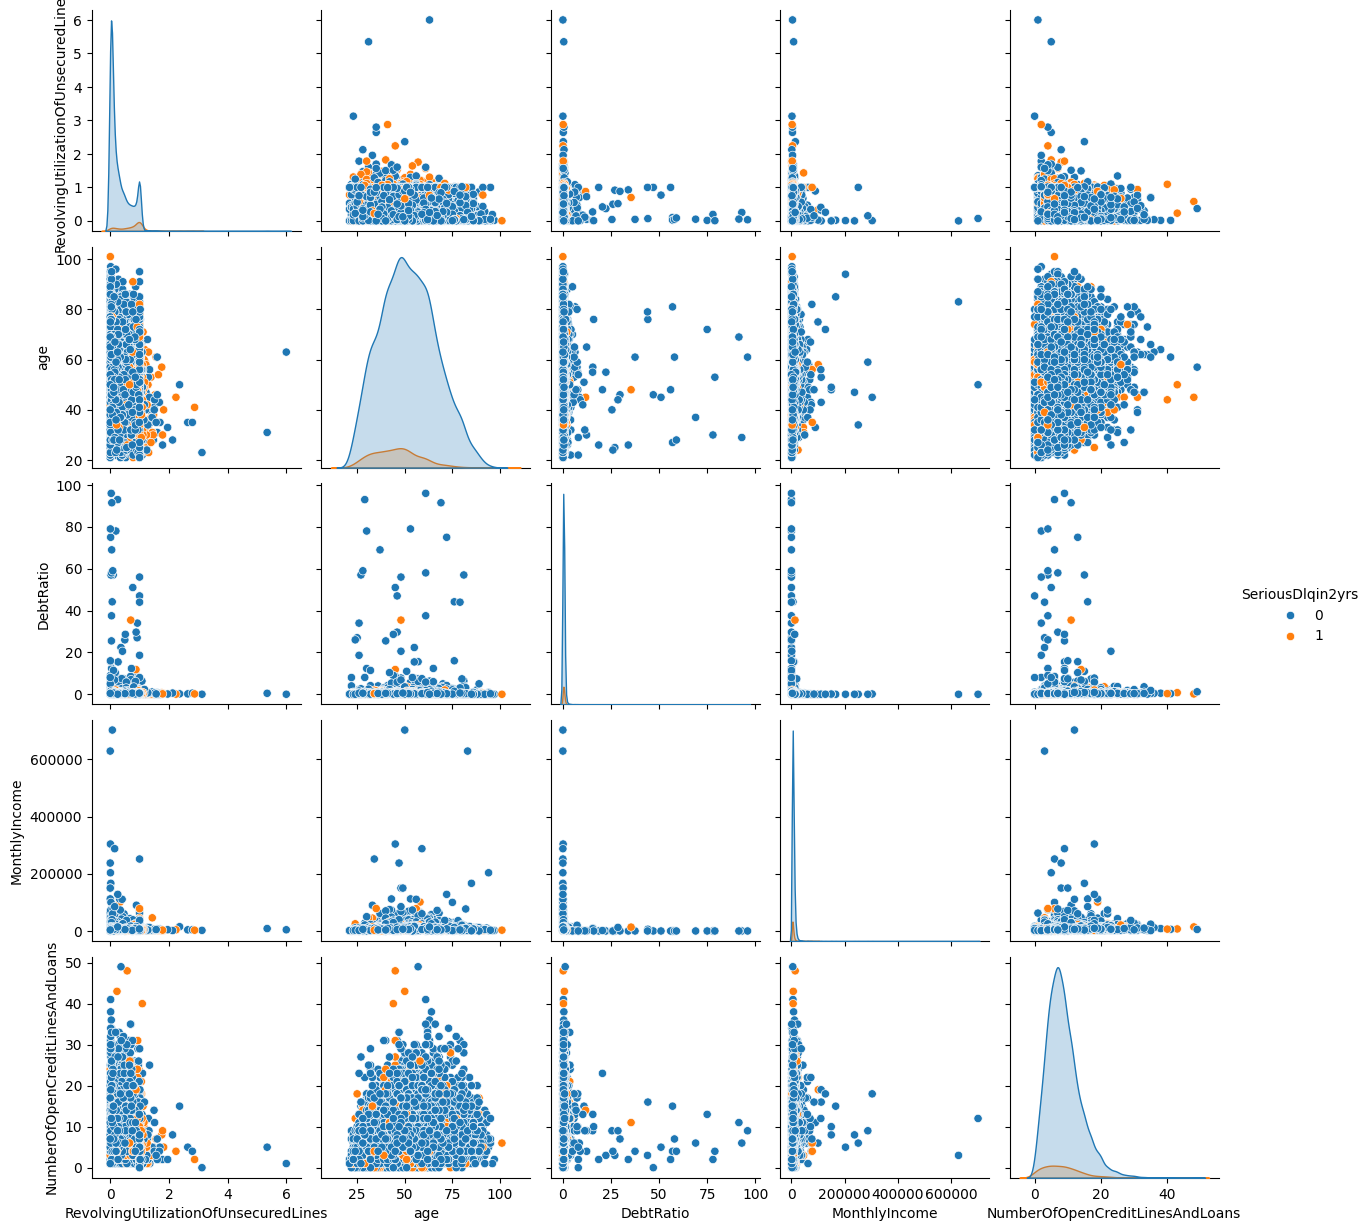

In [7]:
# Análisis visual
sns.pairplot(df, hue='SeriousDlqin2yrs')
plt.show()

In [17]:
# Separar las features numéricas y categóricas
X_num = df.select_dtypes(include=['int64', 'float64']).drop(columns=['SeriousDlqin2yrs'])
X_cat = df.select_dtypes(include=['category'])
y = df['SeriousDlqin2yrs']

# OneHotEncode las features categóricas
encoder = OneHotEncoder(drop='first')
X_cat_encoded = encoder.fit_transform(X_cat)

# Selección de features numéricas mediante SelectKBest y ANOVA
selector_num = SelectKBest(score_func=f_classif, k=6)
selector_num.fit(X_num, y)
selected_features_num = X_num.columns[selector_num.get_support()]

# Selección de features categóricas mediante Mutual Information
selector_cat = SelectKBest(score_func=mutual_info_classif, k=6)
selector_cat.fit(X_cat_encoded, y)
selected_features_cat = encoder.get_feature_names_out(X_cat.columns)[selector_cat.get_support()]

c:\Users\Joaquín\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:779: UserWarning: k=6 is greater than n_features=5. All the features will be returned.
  warnings.warn(


In [18]:
# Combinar las features numéricas y categóricas
X_combined = pd.concat([X_num.reset_index(drop=True), pd.DataFrame(X_cat_encoded.toarray(), columns=encoder.get_feature_names_out(X_cat.columns))], axis=1)

model = RandomForestClassifier()
model.fit(X_combined, y)
selector_model = SelectFromModel(model, max_features=6)
selector_model.fit(X_combined, y)
selected_features_model = X_combined.columns[selector_model.get_support()]

In [ ]:
# Selección de features mediante SFS
rfe = RFE(estimator=model, n_features_to_select=6)
rfe.fit(X_combined, y)
selected_features_rfe = X_combined.columns[rfe.get_support()]

In [23]:
# Selección de features mediante SFS
sfs = SFS(model, k_features=6, forward=True, floating=False, scoring='accuracy', cv=5)
sfs.fit(X_combined, y)
selected_features_sfs = list(sfs.k_feature_names_)

In [25]:
# Selección de features mediante hard-voting

# Combinar todas las listas de features seleccionadas
all_selected_features = list(selected_features_num) + list(selected_features_cat) + list(selected_features_model) + list(selected_features_rfe) + list(selected_features_sfs)

# Contar la frecuencia de cada feature
feature_counter = Counter(all_selected_features)

# Seleccionar las features más comunes (hard-voting)
selected_features_hard_voting = [feature for feature, count in feature_counter.most_common(6)]

In [28]:
# Entrenamiento y validación cruzada

# Modelos a comparar
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [29]:
# Listas de features seleccionadas
feature_lists = [selected_features_num, selected_features_cat, selected_features_model, selected_features_rfe, selected_features_sfs, selected_features_hard_voting]

In [30]:
# Validación cruzada
results = {}
for model_name, model in models.items():
    for i, features in enumerate(feature_lists):
        X_selected = X_combined[features]
        scores = cross_val_score(model, X_selected, y, cv=5, scoring='recall')
        results[f'{model_name} - Feature Set {i+1}'] = scores.mean()

# Mostrar resultados
for key, value in results.items():
    print(f'{key}: {value}')

c:\Users\Joaquín\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Joaquín\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Logistic Regression - Feature Set 1: 0.020481927710843374
Logistic Regression - Feature Set 2: 0.18072289156626506
Logistic Regression - Feature Set 3: 0.09759036144578312
Logistic Regression - Feature Set 4: 0.09759036144578312
Logistic Regression - Feature Set 5: 0.1566265060240964
Logistic Regression - Feature Set 6: 0.09759036144578312
SVM - Feature Set 1: 0.0
SVM - Feature Set 2: 0.1951807228915663
SVM - Feature Set 3: 0.0
SVM - Feature Set 4: 0.0
SVM - Feature Set 5: 0.2060240963855422
SVM - Feature Set 6: 0.0
Gradient Boosting - Feature Set 1: 0.04337349397590361
Gradient Boosting - Feature Set 2: 0.1963855421686747
Gradient Boosting - Feature Set 3: 0.18433734939759033
Gradient Boosting - Feature Set 4: 0.1855421686746988
Gradient Boosting - Feature Set 5: 0.2
Gradient Boosting - Feature Set 6: 0.1855421686746988


In [34]:
# Supongamos que el mejor modelo fue Gradient Boosting con el conjunto de features seleccionado por hard-voting
best_model = GradientBoostingClassifier()
best_features = selected_features_hard_voting

# Optimización de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_combined[best_features], y)

# Evaluación final contra el conjunto de test
X_test = pd.read_csv(r'C:\DATA_SCIENCE\MASTER DATA SCIENCE\Prácticas Máster Data Science\Practicas_Data_Science\Prácticas Python\Ejercicios Sprint 14 - ML Modelos No Supervisados II – PC y Feature Selection\Unidad_02\Practica_Obligatoria\data\credit_npo.csv')
X_test = X_test[best_features]
y_test = X_test['SeriousDlqin2yrs']
y_pred = grid_search.best_estimator_.predict(X_test)
final_recall = recall_score(y_test, y_pred)

print(f'Recall final en el conjunto de test: {final_recall}')

KeyError: "['NumberOfTimes90DaysLate_2+'] not in index"

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.

In [40]:
# Separar las features numéricas y categóricas
X_num = df.select_dtypes(include=['int64', 'float64']).drop(columns=['SeriousDlqin2yrs'])
X_cat = df.select_dtypes(include=['category'])
y = df['SeriousDlqin2yrs']

# OneHotEncode las features categóricas
encoder = OneHotEncoder(drop='first')
X_cat_encoded = encoder.fit_transform(X_cat)

# Combinar las features numéricas y categóricas
X_combined = pd.concat([X_num.reset_index(drop=True), pd.DataFrame(X_cat_encoded.toarray(), columns=encoder.get_feature_names_out(X_cat.columns))], axis=1)

# Estandarizar las features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

In [41]:
# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Determinar el número de componentes en función de la varianza explicada
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1  # 95% de varianza explicada

# Aplicar PCA con el número óptimo de componentes
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f'Número de componentes seleccionados: {n_components}')

Número de componentes seleccionados: 14


In [42]:
# Entrenar el modelo ganador (Gradient Boosting) con los datos transformados por PCA
model = GradientBoostingClassifier()
scores = cross_val_score(model, X_pca, y, cv=5, scoring='recall')

print(f'Recall medio en validación cruzada: {scores.mean()}')

Recall medio en validación cruzada: 0.21445783132530122


In [44]:
# Entrenar el modelo con todos los datos de entrenamiento
model.fit(X_pca, y)

# Cargar y preprocesar el conjunto de prueba
X_test = pd.read_csv(r'C:\DATA_SCIENCE\MASTER DATA SCIENCE\Prácticas Máster Data Science\Practicas_Data_Science\Prácticas Python\Ejercicios Sprint 14 - ML Modelos No Supervisados II – PC y Feature Selection\Unidad_02\Practica_Obligatoria\data\credit_npo.csv')
X_test = X_test.dropna()
X_test_cat = X_test.select_dtypes(include=['category'])
X_test_num = X_test.select_dtypes(include=['int64', 'float64']).drop(columns=['SeriousDlqin2yrs'])
X_test_cat_encoded = encoder.transform(X_test_cat)
X_test_combined = pd.concat([X_test_num.reset_index(drop=True), pd.DataFrame(X_test_cat_encoded.toarray(), columns=encoder.get_feature_names_out(X_test_cat.columns))], axis=1)
X_test_scaled = scaler.transform(X_test_combined)
X_test_pca = pca.transform(X_test_scaled)
y_test = X_test['SeriousDlqin2yrs']

# Predicción y evaluación
y_pred = model.predict(X_test_pca)
final_recall = recall_score(y_test, y_pred)

print(f'Recall final en el conjunto de test: {final_recall}')

c:\Users\Joaquín\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


ValueError: X has 0 features, but OneHotEncoder is expecting 5 features as input.